---
title: Aggregate climate data to different time scales
short_title: Time period aggregation
---

Climate data may be collected and reported at various temporal resolutions (e.g., hourly, daily, or monthly). When preparing data for import into DHIS2, it's important to ensure that the data is aggregated appropriately to match both the type of variable and the target period. Note that you can also aggregate daily data to other period types using the built-in aggregation support in DHIS2.

In [1]:
import xarray as xr
from earthkit import transforms

## Aggregating hourly climate data to daily

Consider the [ERA5-Land data](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview), which in its original version contains data for climatic variables for every hour since 1950. Below, we load a sample file of ERA5-Land hourly temperature and precipitation data for Sierra Leone, and subset it to only the first 3 days of February, 2025:

In [2]:
# open and clean the data
hourly = xr.open_dataset('../data/era5-land-hourly-temp-precip-feb-2025-sierra-leone.nc')
hourly = hourly.drop_vars(['number', 'expver'])

# subset between start and end date
start = '2025-02-01'
end = '2025-02-03'
hourly = hourly.sel(valid_time=slice(start, end))
hourly

<xarray.Dataset> Size: 555kB
Dimensions:     (valid_time: 72, latitude: 31, longitude: 31)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 576B 2025-02-01 ... 2025-02-03T23...
  * latitude    (latitude) float64 248B 9.918 9.818 9.718 ... 7.118 7.018 6.917
  * longitude   (longitude) float64 248B -13.3 -13.2 -13.1 ... -10.5 -10.4 -10.3
Data variables:
    t2m         (valid_time, latitude, longitude) float32 277kB ...
    tp          (valid_time, latitude, longitude) float32 277kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-01-21T18:30 GRIB to CDM+CF via cfgrib-0.9.1...

We see that our dataset contains data for 72 hours (3 days), with data values for temperature (`t2m`) and precipitation (`tp`). Such hourly data are too detailed for DHIS2, where the smallest possible period type is daily. To import them, we next show how to aggregate the hourly values to daily totals.

For the upcoming sections, we will use the capital of Sierra Leone, Freetown, as an example to illustrate the effects of temporal aggregation. We select the grid point closest to the capital to obtain an xarray with only hourly values:

In [3]:
hourly_freetown = hourly.sel(latitude=8.48, longitude=-13.23, method="nearest")

> **Important** When aggregating hourly data to daily values, it is important to account for the local timezone so that hours are assigned to the correct calendar day. Since Sierra Leone uses the same timezone as the climate data (UTC+0), this issue is not addressed in the current notebook but will be covered in a future one.

### Temperature

Before we aggregate the hourly temperature data, let's first inspect and plot the hourly temperature values for the city of Freetown. From this, we see that the hourly temperature data is reported in kelvin, and that the temperature peaks a little past noon each day, as we would expect:

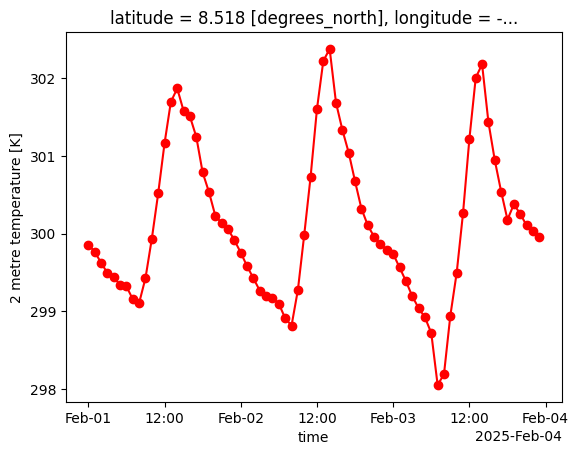

In [11]:
hourly_freetown['t2m'].plot(color='red', marker='o')

A common way to aggregate hourly to **daily temperature** values is to take the **average** temperature for each day. We can do so easily by extracting the `t2m` variable and passing that to the `temporal.daily_reduce` function from the `earthkit.transforms` module. We specify that we want the average temperature value by setting `how='mean'`: 

In [12]:
hourly_temp = hourly_freetown['t2m']
daily_temp = transforms.temporal.daily_reduce(hourly_temp, how='mean')

If we now plot the aggregated data, we see only 3 daily values, as expected. We also reuse the previous y-limits to make it comparable with the hourly chart:

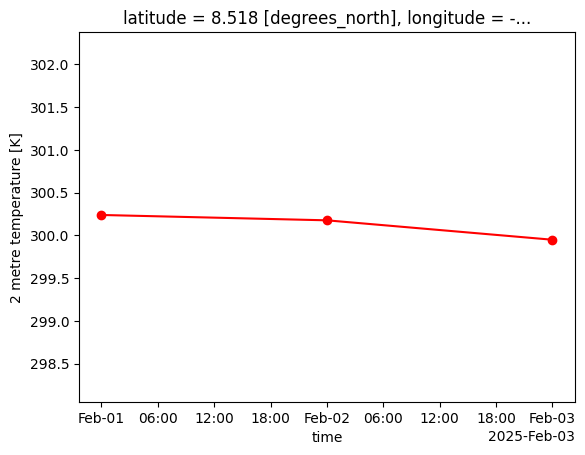

In [13]:
ymin, ymax = hourly_temp.min(), hourly_temp.max()
daily_temp.plot(color='red', marker='o', ylim=(ymin, ymax))

### Precipitation

For the precipitation data, let's do the same as we did for temperature and plot what the hourly precipitation data looks like for the city of Freetown:

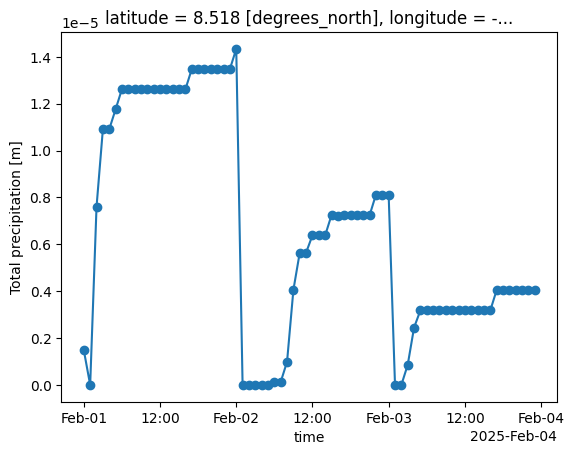

In [56]:
hourly_freetown['tp'].plot(marker='o')

This time we see that there is something strange going on. We see that the ERA5-Land precipitation data is provided as daily **accumulated** precipitation, meaning each time step represents the total precipitation accumulated since the start of each day: 

In [57]:
hourly_freetown['tp'].to_dataframe().head(28)

,latitude,longitude,tp
valid_time,,,
2025-02-01 00:00:00,8.518,-13.203967,0.000001
2025-02-01 01:00:00,8.518,-13.203967,0.000000
2025-02-01 02:00:00,8.518,-13.203967,0.000008
2025-02-01 03:00:00,8.518,-13.203967,0.000011
2025-02-01 04:00:00,8.518,-13.203967,0.000011
2025-02-01 05:00:00,8.518,-13.203967,0.000012
2025-02-01 06:00:00,8.518,-13.203967,0.000013
2025-02-01 07:00:00,8.518,-13.203967,0.000013
2025-02-01 08:00:00,8.518,-13.203967,0.000013


#### How to deaccumulate precipitation data

To make the precipitation data more useful we want to convert from accumulated to **incremental** precipitaton, so we can know how much precipitation occured **during** each hour.

**Step 1: Shift all values to previous hour** 

You may have noticed in the table above that the accumulation precipitation values actually *spill over* into the next day, so that the 0-th hour of each day actually belongs to the previous day. To ensure we aggregate each hour to their respective day we need to shift these values back one hour: 

In [60]:
# shift all values to previous hour, so the values don't spill over to the next day
accum_precip = hourly_freetown['tp']
accum_precip = accum_precip.shift(valid_time=-1)

**Step 2: Calculate the difference between accumulated values**

To calculate the incremental precipitation values, we compute the difference between each consecutive accumulated value:

In [62]:
# convert cumulative to diffs
hourly_precip = accum_precip.diff(dim='valid_time')
hourly_precip = hourly_precip.reindex(valid_time=accum_precip.valid_time)

**Step 3: Handle accumulation reset**

The previous step of calculating differences results in negative values at the boundary between days where the cumulative totals reset. To solve this, the first hour of each day should be replaced with the first accumulated value of each day:

In [63]:
# use cumul values where accumulation resets (00:00) and diff everywhere else
is_reset = accum_precip['valid_time'].dt.hour == 0
hourly_precip = xr.where(is_reset, accum_precip, hourly_precip)

Plotting the data now we can see how the precipitation varies for each hour:

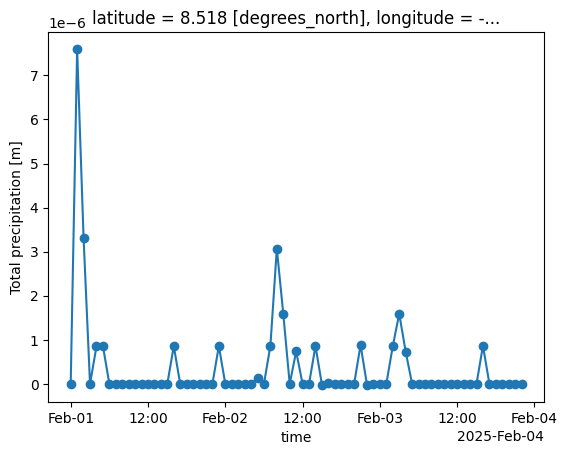

In [64]:
hourly_precip.plot(marker='o')

#### Total daily precipitation

Now that we have the correct hourly precipitation values throughout the day, we can proceed to aggregate from hourly to **daily precipiation**. Daily precipitation is typically calculated as the **sum total** of all the precipitation that happened throughout each day. To do so, we can simply pass the hourly precipitation to `earthkit`'s `temporal.daily_reduce` function, and set `how='sum'`: 

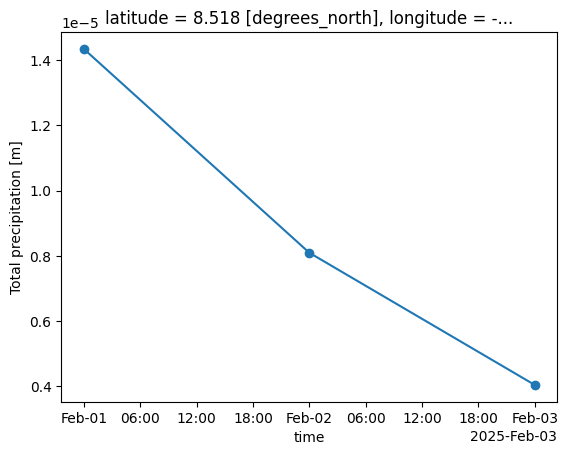

In [66]:
# Alternative 1: Sum of incremental precipitation
daily_precip = transforms.temporal.daily_reduce(hourly_precip, how='sum')
daily_precip.plot(marker='o')

Another way of calculating the total daily precipitation is simply to take the maximum of the original accumulated precipitation values, which produces the same results:

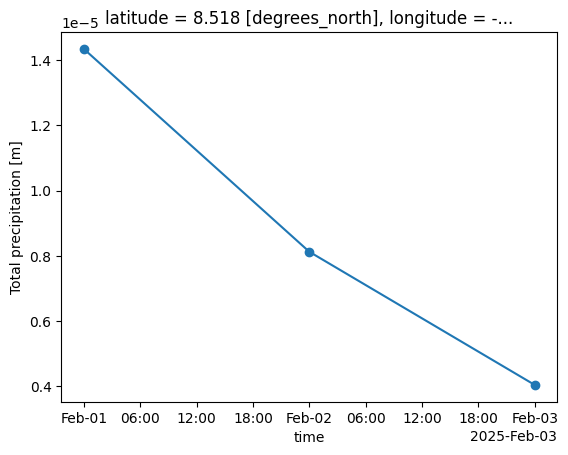

In [67]:
# Alternative 2: Max of daily accumulated precipitation
daily_precip = transforms.temporal.daily_reduce(accum_precip, how='max')
daily_precip.plot(marker='o')

## Aggregating hourly climate data to monthly

We can apply the same approach we used for hourly-to-daily aggregation to produce **monthly summaries**. In the previous section we only looked at the first 3 days of February, so we start by loading the full sample of the same ERA5-Land dataset for February 2025:

In [19]:
hourly = xr.open_dataset('../data/era5-land-hourly-temp-precip-feb-2025-sierra-leone.nc')
hourly = hourly.drop_vars(['number', 'expver'])

Let's select and plot the hourly temperature values for the city of Freetown: 

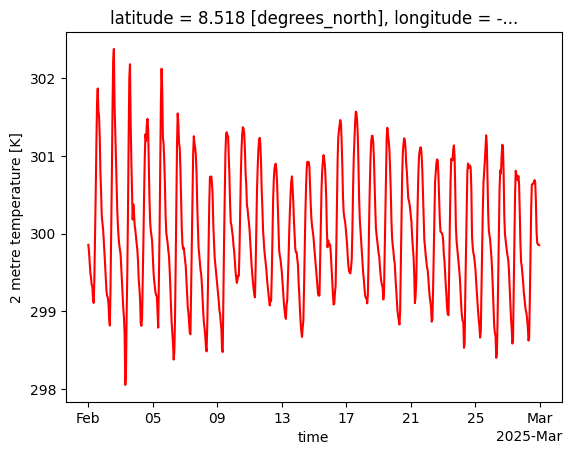

In [20]:
hourly_freetown = hourly.sel(latitude=8.48, longitude=-13.23, method="nearest")
hourly_temp = hourly_freetown['t2m']
hourly_temp.plot(color='red')

To aggregate the daily temperature data to monthly averages, we use `earthkit`'s `temporal.monthly_reduce` function:

In [21]:
monthly_temp = transforms.temporal.monthly_reduce(hourly_temp, how='mean')

Since the original data was only for the month of February, we are left with only a single monthly aggregated value:

In [22]:
monthly_temp.to_dataframe()

,latitude,longitude,t2m
valid_time,,,
2025-02-01,8.518,-13.203967,299.991333


## Next steps

In this notebook we have shown how to aggregate hourly climate data to daily data so that it can be imported into DHIS2. We have also shown how to inspect the temporal aspects of the hourly data, and how aggregation differs for temperature and precipitation variables. We also briefly showed how the same principles can be applied to aggregate daily climate data to monthly. 

Once your gridded climate data has been aggregated to the desired time period, the next step is to spatially aggregate from gridded data to DHIS2 organisation units. See our guide for [aggregating to DHIS2 organisation units](org-unit-aggregation.ipynb). 